# 👋 Welcome to the introduction tutorial

In this tutorial, we will guide you, while using *puncc*, throughout the process of uncertainty quantification in two prediction tasks. By the end of this notebook, you will be able to wrap your own models into conformal predictors and analyze their performance. 

**Table of contents**

- [📈 Conformal Regression](#cr)
    - [💾 Diabetes Dataset](#cr-data)
    - [🔮 Predicton Model](#cr-pm)
    - [⚙️ Conformal Prediction](#cr-cp)
- [📊 Conformal Classification](#cc)
    - [💾 MNIST Dataset](#cc-data)
    - [🔮 Predicton Model](#cc-pm)
    - [⚙️ Conformal Prediction](#cc-cp)


**Links**
- [<img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> Github](https://github.com/deel-ai/puncc)
- [📘 Documentation](https://deel-ai.github.io/puncc/index.html)

## 📈 Conformal Regression  <a class="anchor" id="cr"></a>

Let’s consider a simple regression problem on diabetes data provided in Scikit-learn. We want to evaluate the uncertainty associated with the prediction using inductive (or split) conformal prediction.

### 💾 Diabetes Dataset <a class="anchor" id="cr-data"></a>

The dataset contains information about 442 diabetes patients. The goal is predict from physiological variables a quantitative measure of disease progression in one year.
- There are ten standardized features corresponding to the age, sex, body mass index, average blood pressure, and six blood serum measurements. 
- The target is the measure of diabetes progression during one year for each patient.

For more information, check the official [documentation](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html).

In [1]:
from sklearn import datasets

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

print(f"Features shape: {diabetes_X.shape}")
print(f"Target's shape: {diabetes_y.shape}")

Features shape: (442, 10)
Target's shape: (442,)


From all the features, we want our model to capture only the link between body mass index and the evolution of the disease. 

In [2]:
import numpy as np 

# Use only BMI feature
diabetes_X = diabetes_X[:, 2, np.newaxis]

By construction, data are independent and identically distributed (i.i.d).

Great, we fullfill the prerequisites to apply conformal prediction 👏 !

The next step is spliting the data into three subsets:

* Fit subset ${\cal D_{fit}}$ to train the model.
* Calibration subset ${\cal D_{calib}}$ on which nonconformity scores are
  computed.
* Test subset ${\cal D_{test}}$ on which the prediction intervals are
  estimated.

---
**NOTE**

   Rigorously, for the probabilistic guarantee to hold, the calibration subset
   needs to be resampled for each new example in the test set.

---


The following code implements the aforementioned steps:

In [3]:
# Split the data into training/testing sets
X_train = diabetes_X[:-100]
X_test = diabetes_X[-100:]

# Split the targets into training/testing sets
y_train = diabetes_y[:-100]
y_test = diabetes_y[-100:]

# Split fit and calibration data
X_fit, X_calib = X_train[:-100], X_train[-100:]
y_fit, y_calib = y_train[:-100], y_train[-100:]

### 🔮 Prediction Model <a class="anchor" id="cr-pm"></a>

We consider a simple linear regression model from
[scikit-learn regression module](https://scikit-learn.org/stable/modules/linear_model.html),
to be trained later on ${\cal D_{fit}}$:

In [4]:
from sklearn import linear_model

# Create linear regression model
lin_reg_model = linear_model.LinearRegression()

Such model needs to be wrapped in a wrapper provided in the module deel.puncc.api.prediction. The wrapper makes it possible to use various models from different ML/DL libraries such as Scikit-learn, Keras or XGBoost. For more information about model wrappers and supported ML/DL libraries, we refere the user to the documentation.

For a linear regression from scikit-learn, we use deel.puncc.api.prediction.BasePredictor as follows:

In [5]:
from deel.puncc.api.prediction import BasePredictor

# Create a predictor to wrap the linear regression model defined earlier
# The argument `is_trained` is set to False such that the linear model needs to be
# trained before the calibration. You can initialize it to True if the model is
# already trained and you want to save time.
lin_reg_predictor =  BasePredictor(lin_reg_model, is_trained=False)

### ⚙️ Conformal Prediction <a class="anchor" id="cr-cp"></a>

For this example, the prediction intervals are obtained throught the split
conformal prediction method provided by the class
`deel.puncc.regression.SplitCP`. Other methods are presented
in the [documentation](https://deel-ai.github.io/puncc/regression.html).

In [6]:
from deel.puncc.regression import SplitCP

# Coverage target is 1-alpha = 90%
alpha=.1

# Instanciate the split cp wrapper around the linear predictor.
split_cp = SplitCP(lin_reg_predictor)

# Train model (if argument `is_train` is False) on the fitting dataset and
# compute the residuals on the calibration dataset. 
split_cp.fit(X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib)

## Alternatively, we can randomly select the fit/calib subsets as below 
# split_cp.fit(X=X_train, y=y_train, fit_ratio=.8)

# The `predict` returns the output of the linear model `y_pred` and
# the calibrated interval [`y_pred_lower`, `y_pred_upper`].
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

The library provides several metrics in `deel.puncc.metrics` to evaluate the conformalization procedure. Below, we compute the average empirical coverage and the average empirical width of the prediction intervals on the test examples:

In [7]:
from deel.puncc import metrics

coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)
print(f"Marginal coverage: {coverage:.2f}")
print(f"Average width: {width:.2f}")

Marginal coverage: 0.95
Average width: 211.38


In addition, puncc provides plotting tools in `deel.puncc.plotting` to visualize the prediction intervals and whether or not the observations are covered:

Text(0, 0.5, 'Diabetes progression in one year')

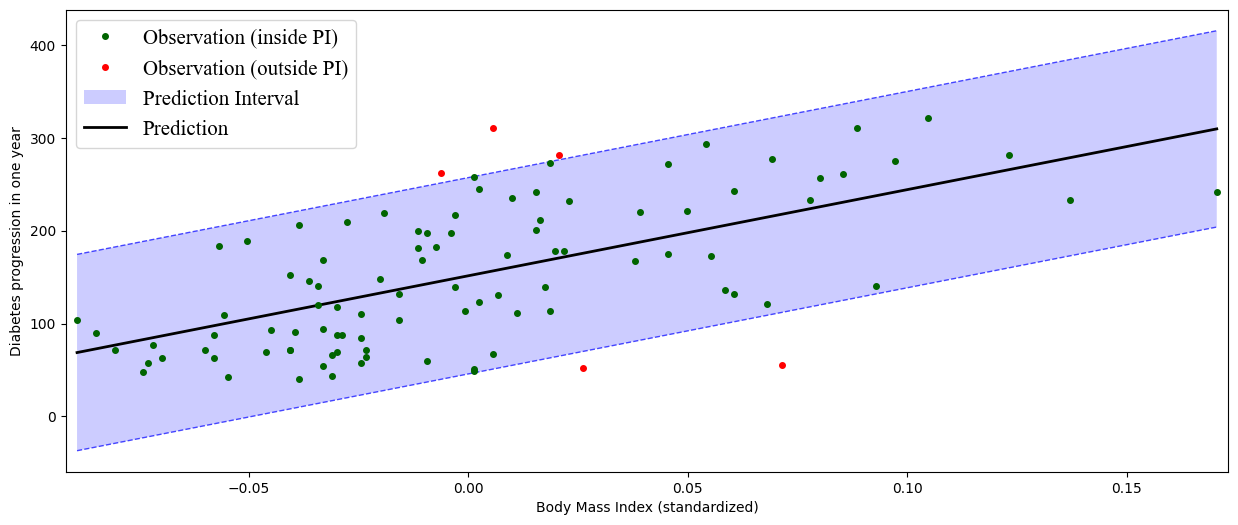

In [8]:
from deel.puncc.plotting import plot_prediction_intervals

# Figure of the prediction bands

ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")

ax.set_xlabel("Body Mass Index (standardized)")
ax.set_ylabel("Diabetes progression in one year")

## 📊 Conformal Classification

Let’s tackle the classic problem of [MNIST handwritten digits](https://en.wikipedia.org/wiki/MNIST_database) classification. The goal is to evaluate through conformal prediction the uncertainty associated with a predictive classifier.

### 💾 MNIST Dataset <a class="anchor" id="cc-data"></a>

MNIST dataset contains a large number of $28\times28$ digit images to which are associated digit labels. As the data generating process is considered i.i.d (check [this post](https://newsletter.altdeep.ai/p/the-story-of-mnist-and-the-perils)), conformal prediction is applicable 👏.

We split the data into three subsets:

* Fit subset ${\cal D_{fit}}$ to train the model.
* Calibration subset ${\cal D_{calib}}$ on which nonconformity scores are computed.
* Test subset ${\cal D_{test}}$ on which the prediction sets are estimated.

---
**NOTE**

   Rigorously, for the probabilistic guarantee to hold, the calibration subset
   needs to be resampled for each new example in the test set.

---


In addition to data preprocessing, the following code implements the aforementioned steps:

In [9]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST Database
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocessing: reshaping and standardization
X_train = X_train.reshape((len(X_train), 28, 28))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((len(X_test), 28 , 28))
X_test = X_test.astype('float32') / 255

# Split fit and calib datasets
X_fit, X_calib  = X_train[:50000], X_train[50000:]
y_fit, y_calib  = y_train[:50000], y_train[50000:]

# One hot encoding of classes
y_fit_cat = to_categorical(y_fit)
y_calib_cat = to_categorical(y_calib)
y_test_cat = to_categorical(y_test)

### 🔮 Prediction model <a class="anchor" id="cc-pm"></a>

We consider a convnet defined as follows:

In [10]:
from tensorflow import random
from tensorflow import keras
from tensorflow.keras import layers

random.set_seed(0)
keras.utils.set_random_seed(0)

# Classification model: convnet composed of two convolution/pooling layers
# and a dense output layer
nn_model = keras.Sequential(
   [
      keras.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dense(10, activation="softmax"),
   ]
)

For the convnet above, we use `deel.puncc.api.prediction.BasePredictor` as wrapper. Note that our model is not already trained (`is_trained = False`), we need to provide the compilation config to the constructor:

In [11]:
from deel.puncc.api.prediction import BasePredictor

# The compilation details are gathered in a dictionnary
compile_kwargs = {"optimizer":"adam", "loss":"categorical_crossentropy","metrics":["accuracy"]}

# Create a predictor to wrap the convnet model defined earlier
class_predictor = BasePredictor(nn_model, is_trained=False, **compile_kwargs)

### ⚙️ Conformal Prediction <a class="anchor" id="cc-cp"></a>

The RAPS procedure is chosen to conformalize our convnet classifier. Such algorithm has two hyparameters $\lambda$ and $k_{reg}$ that encourage smaller prediction sets.

To start off gently, we will ignore the regularization term ($\lambda=0$), which simply turns the procedure into APS:

In [12]:
from deel.puncc.classification import RAPS

# Coverage target is 1-alpha = 90%
alpha = .1

# Instanciate the RAPS wrapper around the convnet predictor.
# The `train` argument is set to True such that the convnet model is trained
# before the calibration. You can initialize it to False if the model is
# already trained and you want to save time.
aps_cp = RAPS(class_predictor, lambd=0, train=True)

# The train details of the convnet are gathered in a dictionnary
fit_kwargs = {"epochs":2, "batch_size":256, "validation_split": .1, "verbose":1}

# Train model (argument `train` is True) on the fitting dataset (w.r.t. the fit config)
# and compute the residuals on the calibration dataset.
aps_cp.fit(X_fit=X_fit, y_fit=y_fit_cat, X_calib=X_calib, y_calib=y_calib, **fit_kwargs)

# The `predict` returns the output of the convnet model `y_pred` and
# the calibrated prediction set `set_pred`.
y_pred, set_pred = aps_cp.predict(X_test, alpha=alpha)

Epoch 1/2
176/176 [==============================] - 16s 89ms/step - loss: 0.6308 - accuracy: 0.8323 - val_loss: 0.2383 - val_accuracy: 0.9274
Epoch 2/2
313/313 [==============================] - 2s 5ms/step


Let's visualize an example of point prediction and set prediction.

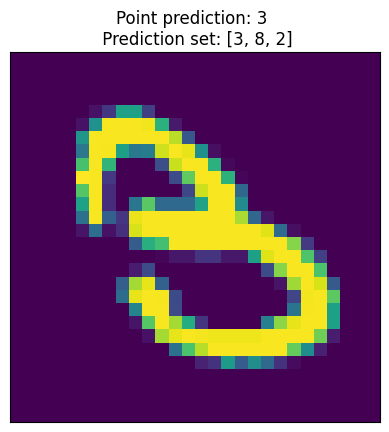

In [13]:
import matplotlib.pyplot as plt

sample = 18

plt.imshow(X_test[sample].reshape((28,28)))
_ = plt.title(f"Point prediction: {np.argmax(y_pred[sample])} \n Prediction set: {set_pred[sample]}")
_ = plt.xticks([])
_ = plt.yticks([])

Our library provides several metrics in `deel.puncc.metrics` to evaluate the conformalization procedure. Below, we compute the average empirical coverage and the average empirical size of the prediction sets on the test examples:

In [14]:
from deel.puncc import metrics

mean_coverage = metrics.classification_mean_coverage(y_test, set_pred)
mean_size = metrics.classification_mean_size(set_pred)

print(f"Empirical coverage : {mean_coverage:.2f}")
print(f"Average set size : {mean_size:.2f}")

Empirical coverage : 0.90
Average set size : 1.03
